In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import seaborn as sns

In [5]:
df=pd.read_csv(r'diabetes.csv')
df.isna().sum()
df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']] = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']].replace(0, np.NaN)
def deal_with_Nan(column):   
    temp = df[df[column].notnull()]
    temp = temp[[column, 'Outcome']].groupby(['Outcome'])[[column]].median().reset_index()
    return temp
df.isna().sum()
columns = df.iloc[:,:-1]
columns 
for column in columns: # dealing with missing values
    deal_with_Nan(column)
    df.loc[(df['Outcome'] == 0 ) & (df[column].isna()), column] = deal_with_Nan(column)[column][0]
    df.loc[(df['Outcome'] == 1 ) &  (df[column].isna()),column] = deal_with_Nan(column)[column][1]
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Pregnancies yes
Glucose no
BloodPressure yes
SkinThickness yes
Insulin yes
BMI yes
DiabetesPedigreeFunction yes
Age yes
Outcome no


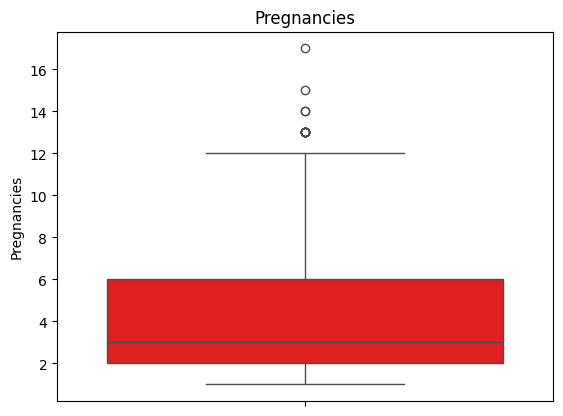

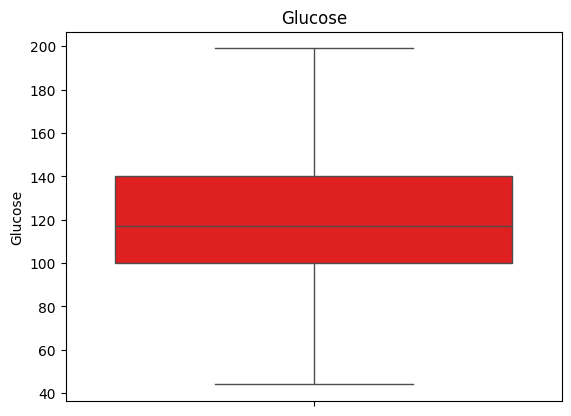

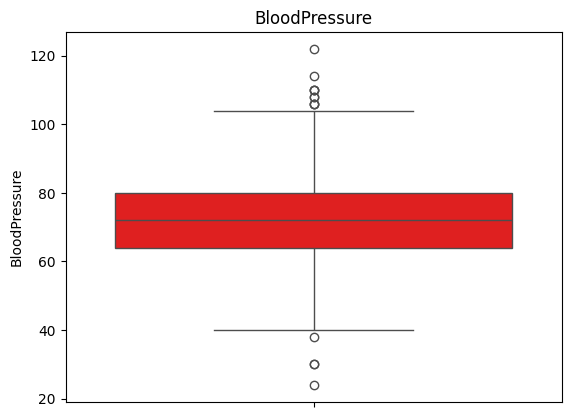

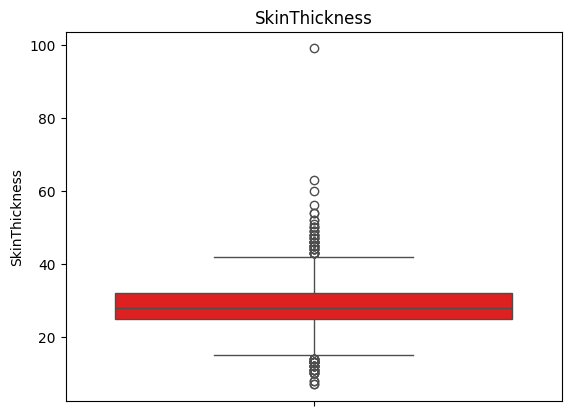

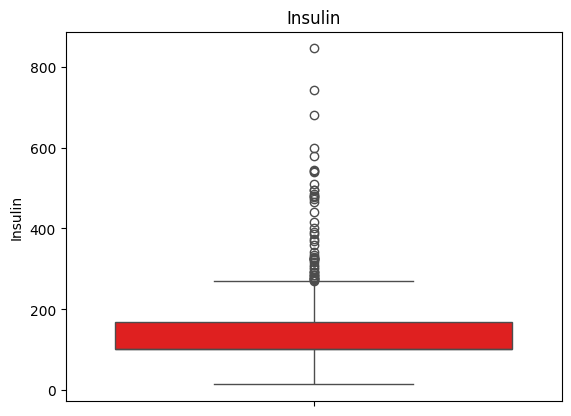

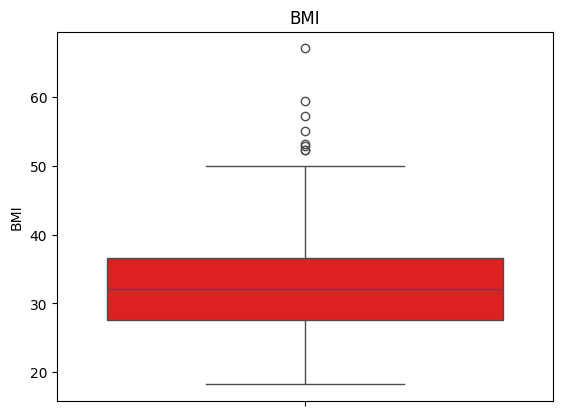

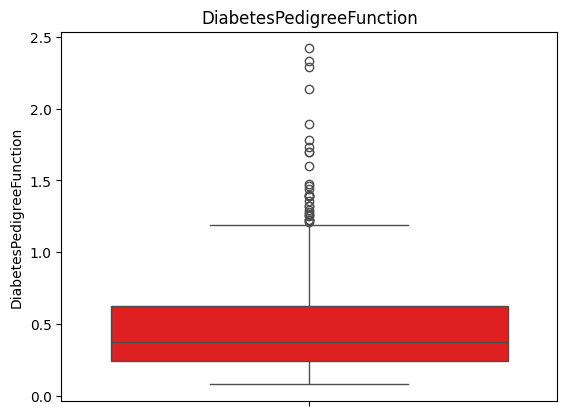

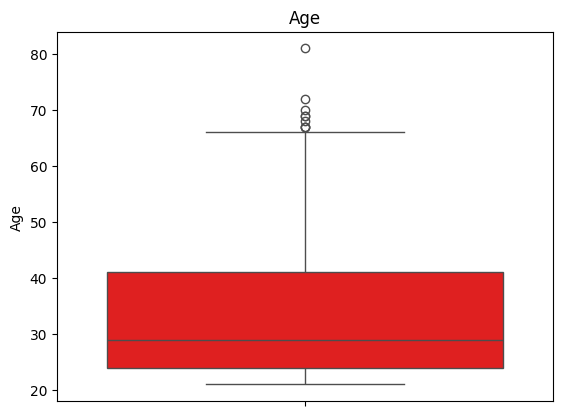

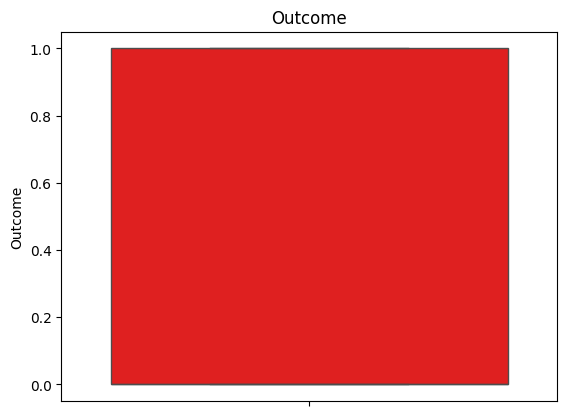

In [6]:
for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):  # Ensure column is numeric
        Q3 = df[column].quantile(0.75)
        Q1 = df[column].quantile(0.25)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Check for outliers
        if (df[column] > upper_bound).any():
            print(column, "yes")
        else:
            print(column, "no")
    else:
        print(column, "not numeric")
for column in df.columns: # plots for detecting outliers
    plt.figure()
    sns.boxplot(df[column], color ="red")
    plt.title(column)
    plt.show()
def clean_outliers(data,column): # function for clearing outliers
    Q3 = df[column].quantile(0.75)
    Q1 = df[column].quantile(0.25)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    lower_filter = lower_bound < data[column]
    upper_filter = upper_bound > data[column]
    cleaned_data = lower_filter & upper_filter 
    data = data[cleaned_data]
    ##print("{} of dataset after column {}".format(data.shape, columns))
    return data
df_clean = df.copy() # clearing outliers (deleting them)
for c in df.columns:
    df_clean = clean_outliers(df_clean,c)
df_clean.shape
X = df_clean.drop('Outcome', axis = 1) # defining what I will be predicting ( the Outcome value)
Y = df_clean['Outcome']


In [7]:
x_train_set=X[0:458]
x_test_set=X[458:573]
x_train=np.array(x_train_set)
x_test=np.array(x_test_set)
y_train_set=Y[0:458]
y_test_set=Y[458:573]
y_train=np.array(y_train_set)
y_test=np.array(y_test_set)

y_train=y_train.T
y_train=y_train.reshape((1,458))
y_test=y_test.T
y_test=y_test.reshape((1,115))
x_train=x_train.T
x_test=x_test.T
def z_normalization(X):
    m = np.mean(X, axis=1, keepdims=True)
    sig = np.std(X, axis=1, keepdims=True)
    normalized_x = (X - m) / sig
    return normalized_x
x_train=z_normalization(x_train)
x_test=z_normalization(x_test)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(8, 458)
(8, 115)
(1, 458)
(1, 115)


In [17]:
def init_params(layers_dims):
    L=len(layers_dims)
    params={}
    for i in range(1,L):
        params["W"+str(i)]=np.random.randn(layers_dims[i],layers_dims[i-1])*np.sqrt(1/layers_dims[i-1])
        params["b"+str(i)]=np.zeros((layers_dims[i],1))
    return params

In [42]:
def linear_model(X,W,b):
    z=np.dot(W,X)+b
    cache=(X,W,b)
    return z,cache
def tan(Z):
    cache=(Z)
    A=np.tanh(Z)
    return A,cache
def sigmoid(Z):
    cache=(Z)
    A=1./(1.+np.exp(-Z))
    return A,cache
def linear_model_activation(Aprev,W,b,activation):
    if activation=="tanh":
        z,linear_cache=linear_model(Aprev,W,b)
        A,activation_cache=tan(z)
    elif activation=="sigmoid":
        z,linear_cache=linear_model(Aprev,W,b)
        A,activation_cache=sigmoid(z)
    cache=(linear_cache,activation_cache)
    return A,cache
def linear_model_LLayer(X,params):
    L=len(params)//2
    caches=[]
    A=X
    for i in range(1,L):
        Aprev=A
        A,cache=linear_model_activation(Aprev,params["W"+str(i)],params["b"+str(i)],"tanh")
        caches.append(cache)
    AL,cache=linear_model_activation(A,params["W"+str(L)],params["b"+str(L)],"sigmoid")
    caches.append(cache)
    return AL,caches

In [43]:
def cost(AL,Y):
    m=Y.shape[1]
    cost=(1./-m)*np.sum(Y*np.log(AL)+(1-Y)*np.log(1-AL),axis=1)
    return cost

In [58]:
def backward_model(dZ,cache):
    A,W,b=cache
    m=A.shape[1]
    dW=(1./m)*np.dot(dZ,A.T)
    db=(1./m)*np.sum(dZ,axis=1,keepdims=True)
    dAprev=np.dot(W.T,dZ)
    return dAprev,dW,db
def tanh_derivation(dA,cache):
    z=cache
    dZ=dA*(1-(np.tanh(z))**2)
    return dZ
def sigmoid_derivation(dA,cache):
    z=cache
    S=1./(1.+np.exp(-z))
    dZ=dA*(S)*(1-S)
    return dZ
def backward_model_activation(dA,cache,activation):
    linear_cache,activation_cache=cache
    if activation=="tanh":
        dZ=tanh_derivation(dA,activation_cache)
        dAprev,dW,db=backward_model(dZ,linear_cache)
    elif activation=="sigmoid":
        dZ=sigmoid_derivation(dA,activation_cache)
        dAprev,dW,db=backward_model(dZ,linear_cache)
    return dAprev,dW,db
def backward_model_LLayer(AL,Y,cache):
    L=len(cache)
    grads={}
    dAL=-(np.divide(Y,AL)-np.divide(1-Y,1-AL))
    dAprev,dW,db=backward_model_activation(dAL,cache[L-1],"sigmoid")
    grads["dW"+str(L)]=dW
    grads["db"+str(L)]=db
    grads["dA"+str(L-1)]=dAprev
    for i in reversed(range(1,L)):
        dAprev,dW,db=backward_model_activation(dAprev,cache[i-1],"tanh")
        grads["dW"+str(i)]=dW
        grads["db"+str(i)]=db
        grads["dA"+str(i-1)]=dAprev
    return grads


In [65]:
def update_params(params,grads):
    L=len(params)//2
    p=copy.deepcopy(params)
    for i in range(1,L+1):
        p["W"+str(i)]=params["W"+str(i)]-(alpha*grads["dW"+str(i)])
        p["b"+str(i)]=params["b"+str(i)]-(alpha*grads["db"+str(i)])
    return p
def actual_predict(Y):
    return np.where(Y>=0.5,1,0)
def predict(X,params):
    y_hat,cache=linear_model_LLayer(X,params)
    return actual_predict(y_hat)
def accuracy(y_hat,y):
    return np.mean(y_hat==y)

In [66]:
def L_model(X,Y,layers_dims,alpha,iterations):
    params=init_params(layers_dims)
    m=X.shape[1]
    n=X.shape[0]
    j_cost=[]
    j_iter=[]
    for i in range(iterations):
        AL,cache=linear_model_LLayer(X,params)
        cost_temp=cost(AL,Y)
        grads=backward_model_LLayer(AL,Y,cache)
        params=update_params(params,grads)
        if i%100==0 or i==iterations-1:
            j_cost.append(cost_temp)
            j_iter.append(i)
    return params,j_cost,j_iter

Accuracy for train data: 90.17467248908298
Accuracy for test data : 84.34782608695653


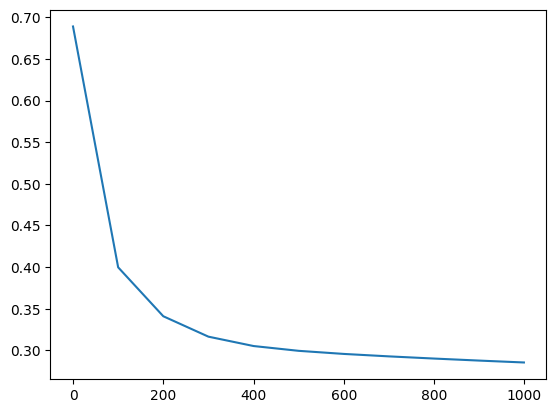

In [85]:
# layers_dims=np.array([8,7,4,2,1])
# alpha=0.035
# iterations=1000
params,j_cost,j_iter=L_model(x_train,y_train,layers_dims,alpha,iterations)
y_hat=predict(x_train,params)
print(f"Accuracy for train data: {accuracy(y_hat,y_train)*100}")
y_hat_test=predict(x_test,params)
print(f"Accuracy for test data : {accuracy(y_hat_test,y_test)*100}")
plt.plot(j_iter,j_cost)

In [82]:
import math
def random_mini_batches(X,Y,mbz):
    m=X.shape[1]
    count_mini=math.floor(m/mbz)
    mini_batches=[]
    permutations=list(np.random.permutation(m))
    shuffled_x=X[:,permutations]
    shuffled_y=Y[:,permutations].reshape((1,m))
    inc=mbz
    for i in range(count_mini):
        mini_batch_x=shuffled_x[:,i*inc:i*inc+inc]
        mini_batch_y=shuffled_y[:,i*inc:i*inc+inc]
        mini_batch=(mini_batch_x,mini_batch_y)
        mini_batches.append(mini_batch)
    if m%inc!=0:
        mini_batch_x=shuffled_x[:,count_mini*inc:count_mini*inc+inc]
        mini_batch_y=shuffled_y[:,count_mini*inc:count_mini*inc+inc]
        mini_batch=(mini_batch_x,mini_batch_y)
        mini_batches.append(mini_batch)
    return mini_batches
        
def L_model_mini_batches(X,Y,layers_dims,alpha,iterations,mini_batch_size):
    params=init_params(layers_dims)
    m=X.shape[1]
    n=X.shape[0]
    j_cost=[]
    j_iter=[]
    for i in range(iterations):
        mini_batches=random_mini_batches(X,Y,mini_batch_size)
        cost_temp=0
        for mini_batch in mini_batches:
            mini_batch_x,mini_batch_y=mini_batch
            AL,cache=linear_model_LLayer(mini_batch_x,params)
            cost_temp+=cost(AL,mini_batch_y)
            grads=backward_model_LLayer(AL,mini_batch_y,cache)
            params=update_params(params,grads)
        cost_avg=cost_temp/m
        if i%100==0 or i==iterations-1:
            j_cost.append(cost_avg)
            j_iter.append(i)
    return params,j_cost,j_iter

Accuracy for train data: 95.63318777292577
Accuracy for test data : 88.69565217391305


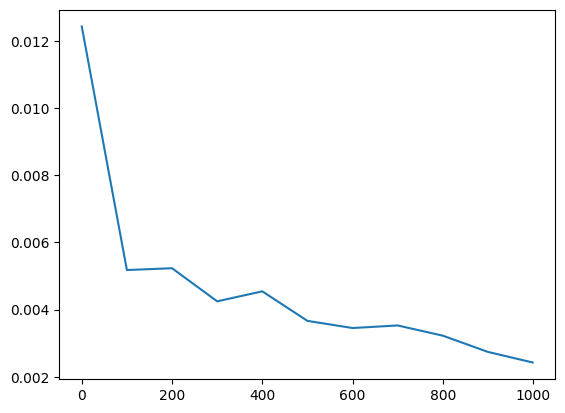

In [101]:
# mini_batch_size=64
# layers_dims=np.array([8,9,4,2,1])
# alpha=0.028
# iterations=1000
params,j_cost,j_iter=L_model_mini_batches(x_train,y_train,layers_dims,alpha,iterations,mini_batch_size)
y_hat=predict(x_train,params)
print(f"Accuracy for train data: {accuracy(y_hat,y_train)*100}")
y_hat_test=predict(x_test,params)
print(f"Accuracy for test data : {accuracy(y_hat_test,y_test)*100}")
plt.plot(j_iter,j_cost)

In [103]:
def init_velocities(params):
    v={}
    L=len(params)//2
    for i in range(1,L+1):
        v["dW"+str(i)]=np.zeros((params["W"+str(i)].shape))
        v["db"+str(i)]=np.zeros((params["b"+str(i)].shape))
    return v
def update_params_with_momentum(params,grads,v,beta,alpha):
    L=len(params)//2
    for i in range(1,L+1):
        v["dW"+str(i)]=beta*v["dW"+str(i)]+(1-beta)*grads["dW"+str(i)]
        v["db"+str(i)]=beta*v["db"+str(i)]+(1-beta)*grads["db"+str(i)]
        params["W"+str(i)]-=alpha*v["dW"+str(i)]
        params["b"+str(i)]-=alpha*v["db"+str(i)]
    return params,v

In [104]:
def model_with_minibatches_momentum(X,Y,layers_dims,alpha,mini_batch_size,beta,iterations):
    params=init_params(layers_dims)
    v=init_velocities(params)
    m=X.shape[1]
    n=X.shape[0]
    j_cost=[]
    j_iter=[]
    for i in range(iterations):
        mini_batches=random_mini_batches(X,Y,mini_batch_size)
        cost_temp=0
        for mini_batch in mini_batches:
            mini_batch_x,mini_batch_y=mini_batch
            AL,cache=linear_model_LLayer(mini_batch_x,params)
            cost_temp+=cost(AL,mini_batch_y)
            grads=backward_model_LLayer(AL,mini_batch_y,cache)
            params,v=update_params_with_momentum(params,grads,v,beta,alpha)
        cost_avg=cost_temp/m
        if i%100==0 or i==iterations-1:
            j_cost.append(cost_avg)
            j_iter.append(i)
    return params,j_cost,j_iter
        

Accuracy for train data: 96.94323144104804
Accuracy for test data : 87.82608695652175


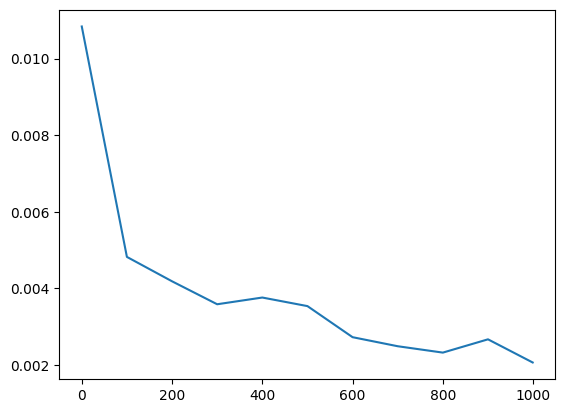

In [117]:
mini_batch_size=64
layers_dims=np.array([8,9,4,2,1])
alpha=0.038
iterations=1000
beta=0.8
params,j_cost,j_iter=model_with_minibatches_momentum(x_train,y_train,layers_dims,alpha,mini_batch_size,beta,iterations)
y_hat=predict(x_train,params)
print(f"Accuracy for train data: {accuracy(y_hat,y_train)*100}")
y_hat_test=predict(x_test,params)
print(f"Accuracy for test data : {accuracy(y_hat_test,y_test)*100}")
plt.plot(j_iter,j_cost)

In [122]:
#Adam Optimization
def init_adam(params):
    L=len(params)//2
    v={}
    s={}
    for i in  range(1,L+1):
        v["dW"+str(i)]=np.zeros((params["W"+str(i)].shape))
        v["db"+str(i)]=np.zeros((params["b"+str(i)].shape))
        s["dW"+str(i)]=np.zeros((params["W"+str(i)].shape))
        s["db"+str(i)]=np.zeros((params["b"+str(i)].shape))
    return v,s
def update_params_with_adam(params,grads,v,s,t,alpha,beta1=0.9,beta2=0.999,epsilon=1e-8):
    L=len(params)//2
    v_corrected={}
    s_corrected={}
    for i in range(1,L+1):
        v["dW"+str(i)]=beta1*v["dW"+str(i)]+(1-beta1)*grads["dW"+str(i)]
        v["db"+str(i)]=beta1*v["db"+str(i)]+(1-beta1)*grads["db"+str(i)]
        v_corrected["dW"+str(i)]=v["dW"+str(i)]/(1-beta1**t)
        v_corrected["db"+str(i)]=v["db"+str(i)]/(1-beta1**t)
        s["dW"+str(i)]=beta2*s["dW"+str(i)]+(1-beta2)*grads["dW"+str(i)]**2
        s["db"+str(i)]=beta2*s["db"+str(i)]+(1-beta2)*grads["db"+str(i)]**2
        s_corrected["dW"+str(i)]=s["dW"+str(i)]/(1-beta2**t)
        s_corrected["db"+str(i)]=s["db"+str(i)]/(1-beta2**t)
        params["W"+str(i)]-=alpha*(v_corrected["dW"+str(i)]/(np.sqrt(s_corrected["dW"+str(i)])+epsilon))
        params["b"+str(i)]-=alpha*(v_corrected["db"+str(i)]/(np.sqrt(s_corrected["db"+str(i)])+epsilon))
    return params,v,s,v_corrected,s_corrected

In [150]:
def model_with_adam(X,Y,layers_dims,beta,beta1,beta2,epsilon,num_epochs,alpha,mini_batch_size):
    params=init_params(layers_dims)
    v,s=init_adam(params)
    m=X.shape[1]
    n=X.shape[0]
    j_cost=[]
    j_iter=[]
    t=1
    for i in range(num_epochs):
        mini_batches=random_mini_batches(X,Y,mini_batch_size)
        cost_temp=0
        for mini_batch in mini_batches:
            mini_batch_x,mini_batch_y=mini_batch
            AL,cache=linear_model_LLayer(mini_batch_x,params)
            cost_temp+=cost(AL,mini_batch_y)
            grads=backward_model_LLayer(AL,mini_batch_y,cache)
            params,v,s,_,_=update_params_with_adam(params,grads,v,s,t,alpha,beta1,beta2,epsilon)
        t+=1
        cost_avg=cost_temp/m
        if i%10==0 or i==iterations-1:
            j_cost.append(cost_avg)
            j_iter.append(i)
    return params,j_cost,j_iter

Accuracy for train data: 98.2532751091703
Accuracy for test data : 88.69565217391305


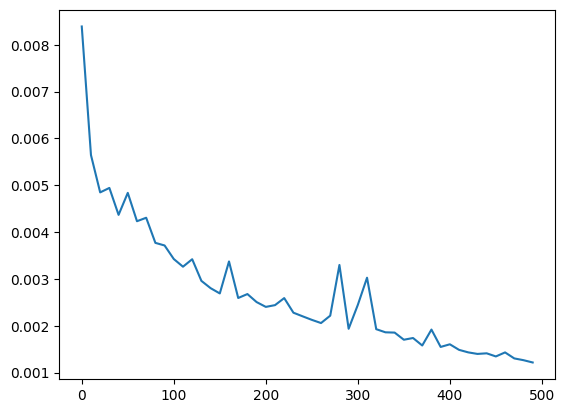

In [272]:
beta=0.9
beta1=0.9
beta2=0.999
mini_batch_size=64
epsilon=1e-8
num_epochs=500
layers_dims=np.array([8,7,4,2,1])
alpha=0.008
params,j_cost,j_iter=model_with_adam(x_train,y_train,layers_dims,beta,beta1,beta2,epsilon,num_epochs,alpha,mini_batch_size)
y_hat=predict(x_train,params)
print(f"Accuracy for train data: {accuracy(y_hat,y_train)*100}")
y_hat_test=predict(x_test,params)
print(f"Accuracy for test data : {accuracy(y_hat_test,y_test)*100}")
plt.plot(j_iter,j_cost)

In [184]:
# 89.5% accuracy 
with open('parameters.txt', 'w') as file:
    # write variables using string formatting
    file.write("params: {}\n".format(params))